In [46]:
import pandas as pd
import numpy as np
import os
import sys
import json
from pathlib import Path
import matplotlib.pyplot as plt


BASE_DIR = Path.cwd().parent.parent
DATA_DIR = os.path.join(BASE_DIR, "data", "data_final")
CSV_PATH = os.path.join(BASE_DIR, "data", "data_final", "final_dataset.csv")
NOVELTY_PATH = os.path.join(DATA_DIR, "knn_faiss_novelty.csv")

sys.path.insert(0, str(BASE_DIR))

from src.data_utils import load_final_data_with_embeddings

In [47]:
df = load_final_data_with_embeddings(CSV_PATH, DATA_DIR)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [48]:
knn_results = pd.read_csv(NOVELTY_PATH)
knn_results["neighbor_distances"] = knn_results["neighbor_distances"].apply(lambda x: json.loads(x))
knn_results["novelty_score"] = knn_results["neighbor_distances"].apply(lambda x: np.mean(x[:20]))
print(knn_results.info())

# Check for crazy distance values
print("\n" + "="*80)
print("Checking for outlier distance values...")
print("="*80)

max_distances = []
min_distances = []
mean_distances = []

for idx, row in knn_results.iterrows():
    dists = np.array(row["neighbor_distances"])
    max_distances.append(np.max(dists))
    min_distances.append(np.min(dists))
    mean_distances.append(np.mean(dists))

max_distances = np.array(max_distances)
min_distances = np.array(min_distances)
mean_distances = np.array(mean_distances)

print(f"\nOverall distance statistics:")
print(f"Max distance across all movies: {np.max(max_distances):.6f}")
print(f"Min distance across all movies: {np.min(min_distances):.6f}")
print(f"Mean of mean distances: {np.mean(mean_distances):.6f}")
print(f"Std of mean distances: {np.std(mean_distances):.6f}")

# Find movies with extremely large distances (> 100, which is way too high for cosine distance)
outlier_threshold = 100
outlier_mask = max_distances > outlier_threshold

if np.any(outlier_mask):
    outlier_indices = np.where(outlier_mask)[0]
    print(f"\n{len(outlier_indices)} movies have distances > {outlier_threshold}:")
    
    for idx in outlier_indices[:10]:  # Show first 10
        movie_id = knn_results.iloc[idx]["movie_id"]
        movie_title = df[df["movie_id"] == movie_id]["title"].values[0] if movie_id in df["movie_id"].values else "Unknown"
        max_dist = max_distances[idx]
        mean_dist = mean_distances[idx]
        print(f"  - {movie_title} ({movie_id}): max={max_dist:.2e}, mean={mean_dist:.2e}")
    
    # Filter out outliers
    print(f"\nFiltering out {len(outlier_indices)} movies with outlier distances...")
    knn_results = knn_results[~outlier_mask].reset_index(drop=True)
    print(f"Remaining movies: {len(knn_results)}")
else:
    print(f"\nNo movies with distances > {outlier_threshold} found.")
    
print("="*80)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            92374 non-null  object 
 1   neighbor_ids        92374 non-null  object 
 2   neighbor_distances  92374 non-null  object 
 3   novelty_score       92374 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.8+ MB
None

Checking for outlier distance values...

Overall distance statistics:
Max distance across all movies: 2.000000
Min distance across all movies: -1.000000
Mean of mean distances: 0.384658
Std of mean distances: 0.105068

No movies with distances > 100 found.


Checking for invalid distance values...

Found 398 movies with invalid distance values:
  movie_id  max_distance  min_distance  mean_distance  has_nan  has_inf                               title
   Q158047            -1            -1           -1.0    False    False                      The Blue Angel
  Q7366209            -1            -1           -1.0    False    False                        Rookery Nook
  Q7339592            -1            -1           -1.0    False    False                    Roadhouse Nights
  Q7339549            -1            -1           -1.0    False    False                    Road to Paradise
  Q7337025            -1            -1           -1.0    False    False                         River's End
  Q7313049            -1            -1           -1.0    False    False                           Renegades
  Q6679908            -1            -1           -1.0    False    False          Lord Richard in the Pantry
  Q6675927            -1            -1          

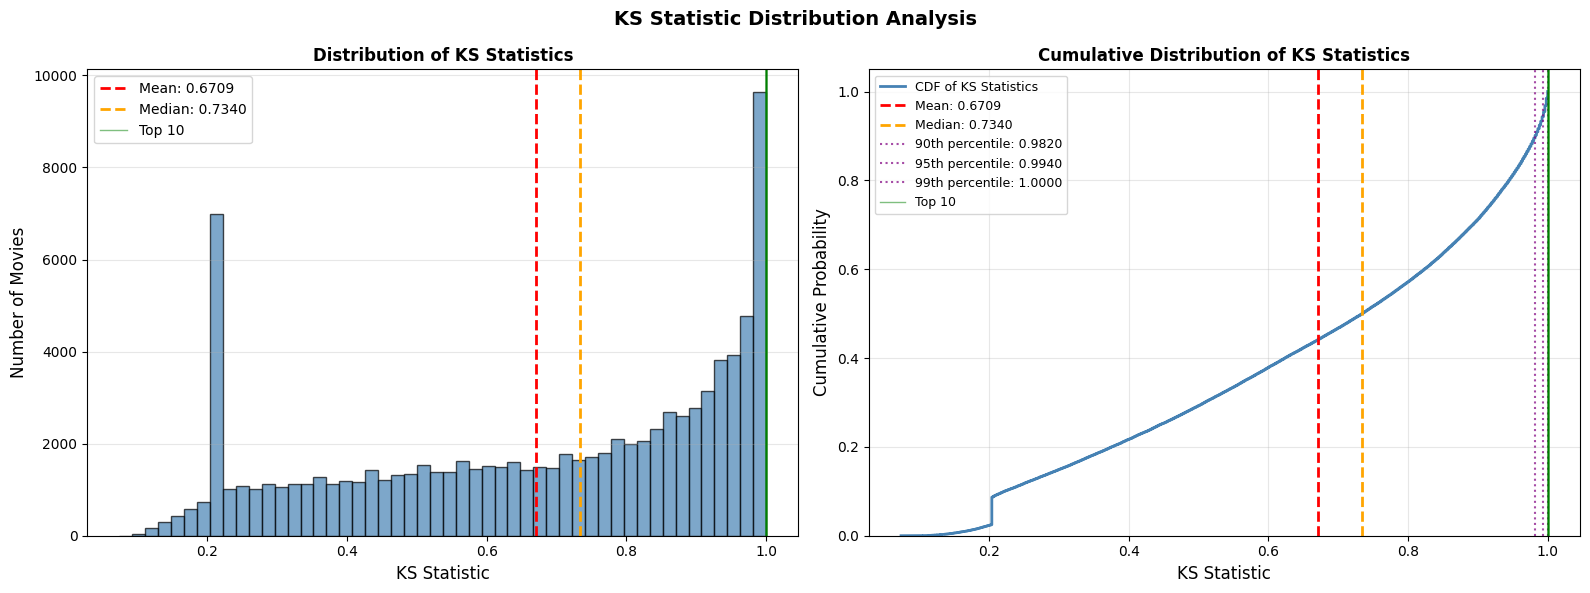

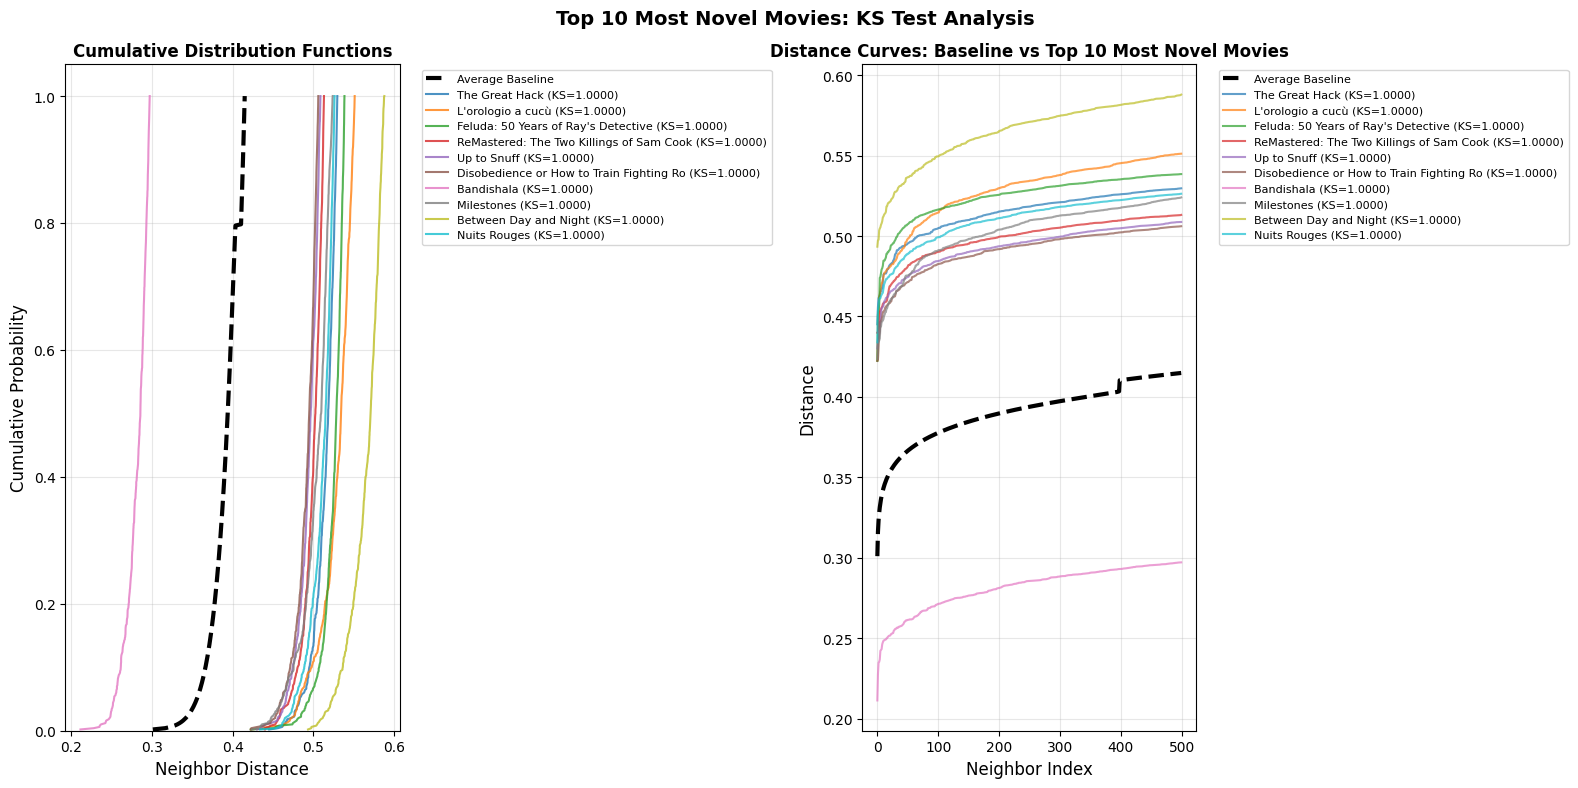

In [49]:
# First, check for movies with crazy distance values
print("Checking for invalid distance values...")

# Check each movie's distances
crazy_movies = []
for idx, row in knn_results.iterrows():
    movie_id = row["movie_id"]
    distances = np.array(row["neighbor_distances"])
    
    # Check for extreme values (cosine distance should be between 0 and 2)
    if np.any(distances > 2) or np.any(distances < 0) or np.any(np.isnan(distances)) or np.any(np.isinf(distances)):
        crazy_movies.append({
            "movie_id": movie_id,
            "max_distance": np.max(distances),
            "min_distance": np.min(distances),
            "mean_distance": np.mean(distances),
            "has_nan": np.any(np.isnan(distances)),
            "has_inf": np.any(np.isinf(distances))
        })

if len(crazy_movies) > 0:
    print(f"\nFound {len(crazy_movies)} movies with invalid distance values:")
    crazy_df = pd.DataFrame(crazy_movies)
    crazy_df = crazy_df.merge(df[["movie_id", "title"]], on="movie_id", how="left")
    print(crazy_df.to_string(index=False))
    print("\nThese movies will be excluded from analysis.")
    
    # Filter out crazy movies
    crazy_movie_ids = set(crazy_df["movie_id"].values)
    knn_results_clean = knn_results[~knn_results["movie_id"].isin(crazy_movie_ids)].copy()
    print(f"\nFiltered dataset: {len(knn_results_clean)} movies (removed {len(crazy_movies)})")
else:
    print("No invalid distance values found.")
    knn_results_clean = knn_results.copy()

# Calculate average baseline distribution of neighbor distances
# Get the average distance at each neighbor position (like epsilon_ball_analysis)
print("\nCalculating average baseline distribution...")

# Calculate average at each position for baseline
max_neighbors = max(len(dist) for dist in knn_results_clean["neighbor_distances"])
print(f"Maximum number of neighbors: {max_neighbors}")

all_distances_matrix = []
for dist in knn_results_clean["neighbor_distances"]:
    padded = np.array(dist + [np.nan] * (max_neighbors - len(dist)))
    all_distances_matrix.append(padded)

all_distances_matrix = np.array(all_distances_matrix)
average_distances = np.nanmean(all_distances_matrix, axis=0)
print(f"Average baseline distribution calculated with {len(average_distances)} neighbors")
print(f"Baseline mean: {np.nanmean(average_distances):.6f}, std: {np.nanstd(average_distances):.6f}")

# Use the average_distances as baseline for KS test
baseline_distances = average_distances[~np.isnan(average_distances)]

# Define KS test function directly using numpy (to avoid scipy import issues)
def kolmogorov_smirnov_test(data1, data2):
    """
    Perform Kolmogorov-Smirnov test to compare two distance distributions.
    Implemented directly using numpy to avoid scipy import issues.
    """
    if len(data1) == 0 or len(data2) == 0:
        raise ValueError("Both distance arrays must be non-empty")
    
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = len(data1)
    n2 = len(data2)
    
    # Compute empirical CDFs
    all_data = np.concatenate([data1, data2])
    all_data_sorted = np.sort(all_data)
    
    # CDF for data1
    cdf1 = np.searchsorted(data1, all_data_sorted, side='right') / n1
    # CDF for data2
    cdf2 = np.searchsorted(data2, all_data_sorted, side='right') / n2
    
    # KS statistic is the maximum difference between CDFs
    statistic = np.max(np.abs(cdf1 - cdf2))
    
    # Approximate p-value using Kolmogorov distribution
    # For large samples, use the asymptotic approximation
    en = np.sqrt(n1 * n2 / (n1 + n2))
    # Simple approximation for p-value (more accurate for large samples)
    # Using the formula: p ≈ 2 * exp(-2 * (en * D)^2) for large n
    p_value = 2 * np.exp(-2 * (en * statistic) ** 2)
    # Cap p-value at 1.0
    p_value = min(p_value, 1.0)
    
    return statistic, p_value

# Perform KS test for each movie against the baseline distribution
print("\nPerforming KS tests for all movies...")
ks_results = []

for idx, row in knn_results_clean.iterrows():
    movie_id = row["movie_id"]
    movie_distances = np.array(row["neighbor_distances"])
    
    # Perform KS test comparing this movie's distances to baseline
    try:
        ks_statistic, p_value = kolmogorov_smirnov_test(movie_distances, baseline_distances)
        
        ks_results.append({
            "movie_id": movie_id,
            "ks_statistic": ks_statistic,
            "ks_p_value": p_value
        })
    except Exception as e:
        print(f"Error processing movie {movie_id}: {e}")
        continue
    
    if (idx + 1) % 10000 == 0:
        print(f"Processed {idx + 1} movies...")

ks_df = pd.DataFrame(ks_results)
print(f"\nKS tests completed for {len(ks_df)} movies")

# Statistics for KS statistic distribution
ks_stats = ks_df["ks_statistic"]
print("\n" + "="*80)
print("KS Statistic Distribution Statistics:")
print("="*80)
print(f"Total movies: {len(ks_stats)}")
print(f"Mean: {ks_stats.mean():.6f}")
print(f"Median: {ks_stats.median():.6f}")
print(f"Std: {ks_stats.std():.6f}")
print(f"Min: {ks_stats.min():.6f}")
print(f"Max: {ks_stats.max():.6f}")
print(f"\nPercentiles:")
print(f"  5th:  {ks_stats.quantile(0.05):.6f}")
print(f"  25th: {ks_stats.quantile(0.25):.6f}")
print(f"  50th: {ks_stats.quantile(0.50):.6f}")
print(f"  75th: {ks_stats.quantile(0.75):.6f}")
print(f"  90th: {ks_stats.quantile(0.90):.6f}")
print(f"  95th: {ks_stats.quantile(0.95):.6f}")
print(f"  99th: {ks_stats.quantile(0.99):.6f}")
print("="*80)

# Merge with movie titles and year
ks_with_titles = ks_df.merge(df[["movie_id", "title", "year"]], on="movie_id", how="left")

# Sort by KS statistic (higher = more different from average = more novel)
ks_with_titles = ks_with_titles.sort_values("ks_statistic", ascending=False)

# Get top 10 most novel movies
top_10_novel = ks_with_titles.head(10)[["movie_id", "title", "year", "ks_statistic", "ks_p_value"]]
print("\n" + "="*80)
print("Top 10 Most Novel Movies (by KS test statistic):")
print("="*80)
for i, (idx, row) in enumerate(top_10_novel.iterrows(), 1):
    year_str = f"{int(row['year'])}" if pd.notna(row['year']) else "N/A"
    print(f"{i}. {row['title']} ({year_str}) - KS={row['ks_statistic']:.6f}, p={row['ks_p_value']:.6e}")
print("="*80)

# Display as DataFrame
print("\nTop 10 Most Novel Movies DataFrame:")
print(top_10_novel.to_string(index=False))

# Visualize KS statistic distribution
fig_dist, (ax_dist1, ax_dist2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Histogram of KS statistics
ax_dist1.hist(
    ks_stats,
    bins=50,
    alpha=0.7,
    edgecolor="black",
    color="steelblue",
    density=False
)
ax_dist1.axvline(
    ks_stats.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {ks_stats.mean():.4f}"
)
ax_dist1.axvline(
    ks_stats.median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {ks_stats.median():.4f}"
)
# Mark top 10
top_10_ks_values = top_10_novel["ks_statistic"].values
for i, ks_val in enumerate(top_10_ks_values):
    ax_dist1.axvline(
        ks_val,
        color="green",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
        label="Top 10" if i == 0 else ""
    )
ax_dist1.set_xlabel("KS Statistic", fontsize=12)
ax_dist1.set_ylabel("Number of Movies", fontsize=12)
ax_dist1.set_title("Distribution of KS Statistics", fontsize=12, fontweight="bold")
ax_dist1.legend()
ax_dist1.grid(True, alpha=0.3, axis="y")

# Plot 2: Cumulative distribution of KS statistics
ks_sorted = np.sort(ks_stats)
ks_cdf = np.arange(1, len(ks_sorted) + 1) / len(ks_sorted)
ax_dist2.plot(ks_sorted, ks_cdf, linewidth=2, color="steelblue", label="CDF of KS Statistics")
ax_dist2.axvline(
    ks_stats.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {ks_stats.mean():.4f}"
)
ax_dist2.axvline(
    ks_stats.median(),
    color="orange",
    linestyle="--",
    linewidth=2,
    label=f"Median: {ks_stats.median():.4f}"
)
# Mark percentiles
for p, label in [(0.90, "90th"), (0.95, "95th"), (0.99, "99th")]:
    p_val = ks_stats.quantile(p)
    ax_dist2.axvline(
        p_val,
        color="purple",
        linestyle=":",
        linewidth=1.5,
        alpha=0.7,
        label=f"{label} percentile: {p_val:.4f}"
    )
# Mark top 10
for i, ks_val in enumerate(top_10_ks_values):
    ax_dist2.axvline(
        ks_val,
        color="green",
        linestyle="-",
        linewidth=1,
        alpha=0.5,
        label="Top 10" if i == 0 else ""
    )
ax_dist2.set_xlabel("KS Statistic", fontsize=12)
ax_dist2.set_ylabel("Cumulative Probability", fontsize=12)
ax_dist2.set_title("Cumulative Distribution of KS Statistics", fontsize=12, fontweight="bold")
ax_dist2.legend(fontsize=9)
ax_dist2.grid(True, alpha=0.3)
ax_dist2.set_ylim([0, 1.05])

fig_dist.suptitle(
    "KS Statistic Distribution Analysis",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

# Create visualization similar to epsilon_ball_analysis style
# Two-panel layout: CDF comparison and histogram/distance curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Sort baseline distances for CDF
baseline_sorted = np.sort(baseline_distances)
baseline_cdf = np.arange(1, len(baseline_sorted) + 1) / len(baseline_sorted)

# Plot 1: CDF comparison (similar to epsilon_ball_analysis)
ax1.plot(
    baseline_sorted, 
    baseline_cdf, 
    label="Average Baseline", 
    linewidth=3, 
    color="black", 
    linestyle="--"
)

# Plot CDFs for top 10 most novel movies
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i, (idx, row) in enumerate(top_10_novel.iterrows()):
    movie_id = row["movie_id"]
    movie_row = knn_results_clean[knn_results_clean["movie_id"] == movie_id]
    if not movie_row.empty:
        movie_distances = np.array(movie_row.iloc[0]["neighbor_distances"])
        movie_sorted = np.sort(movie_distances)
        movie_cdf = np.arange(1, len(movie_sorted) + 1) / len(movie_sorted)
        
        title_short = row["title"][:40] if len(row["title"]) > 40 else row["title"]
        ax1.plot(
            movie_sorted, 
            movie_cdf, 
            label=f"{title_short} (KS={row['ks_statistic']:.4f})", 
            linewidth=1.5,
            color=colors[i],
            alpha=0.8
        )

ax1.set_xlabel("Neighbor Distance", fontsize=12)
ax1.set_ylabel("Cumulative Probability", fontsize=12)
ax1.set_title("Cumulative Distribution Functions", fontsize=12, fontweight="bold")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Plot 2: Distance curves over neighbor index (original style but improved)
ax2.plot(
    average_distances[:1000], 
    label="Average Baseline", 
    linewidth=3, 
    color="black", 
    linestyle="--"
)

for i, (idx, row) in enumerate(top_10_novel.iterrows()):
    movie_id = row["movie_id"]
    movie_row = knn_results_clean[knn_results_clean["movie_id"] == movie_id]
    if not movie_row.empty:
        distances = movie_row.iloc[0]["neighbor_distances"]
        title_short = row["title"][:40] if len(row["title"]) > 40 else row["title"]
        ax2.plot(
            distances[:1000], 
            alpha=0.7, 
            label=f"{title_short} (KS={row['ks_statistic']:.4f})", 
            color=colors[i], 
            linewidth=1.5
        )

ax2.set_xlabel("Neighbor Index", fontsize=12)
ax2.set_ylabel("Distance", fontsize=12)
ax2.set_title("Distance Curves: Baseline vs Top 10 Most Novel Movies", fontsize=12, fontweight="bold")
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Add overall title
fig.suptitle(
    "Top 10 Most Novel Movies: KS Test Analysis",
    fontsize=14,
    fontweight="bold"
)

plt.tight_layout()
plt.show()

In [58]:
# get the top 100 movies with the highest ks statistics
for _, row in ks_with_titles[ks_with_titles["year"] == 2020].sort_values("ks_statistic", ascending=False).head(100).iterrows():
    print(f"Title: {row['title']}, KS Statistic: {row['ks_statistic']} Year: {row['year']}")

Title: Vaanam Kottattum, KS Statistic: 1.0 Year: 2020
Title: Swimming Out Till the Sea Turns Blue, KS Statistic: 1.0 Year: 2020
Title: Raat Akeli Hai, KS Statistic: 1.0 Year: 2020
Title: We Hold the Line, KS Statistic: 1.0 Year: 2020
Title: You and I, KS Statistic: 1.0 Year: 2020
Title: Into the Deep: The Submarine Murder Case, KS Statistic: 1.0 Year: 2020
Title: The Fandom, KS Statistic: 1.0 Year: 2020
Title: Enemies of the State, KS Statistic: 1.0 Year: 2020
Title: Onbathu Kuzhi Sampath, KS Statistic: 1.0 Year: 2020
Title: London Confidential, KS Statistic: 1.0 Year: 2020
Title: Searching-4 Tabernero, KS Statistic: 1.0 Year: 2020
Title: Jathi Ratnalu, KS Statistic: 1.0 Year: 2020
Title: Last Drop, KS Statistic: 1.0 Year: 2020
Title: Folklore: The Long Pond Studio Sessions, KS Statistic: 1.0 Year: 2020
Title: Gagarine, KS Statistic: 1.0 Year: 2020
Title: Not My Responsibility, KS Statistic: 1.0 Year: 2020
Title: A Secret Love, KS Statistic: 1.0 Year: 2020
Title: Sandeep Aur Pinky Fara

In [51]:
knn_results["novelty_score"].describe()

count    92374.000000
mean         0.332787
std          0.097207
min         -1.000000
25%          0.311450
50%          0.335835
75%          0.362833
max          0.567563
Name: novelty_score, dtype: float64

In [52]:
knn_results[knn_results["movie_id"] == "Q19089"]

,movie_id,neighbor_ids,neighbor_distances,novelty_score
43372,Q19089,"['Q320423', 'Q332368', 'Q106440', 'Q107914', '...","[0.20739829540252686, 0.23598015308380127, 0.2...",0.275


In [53]:
df_merged = df.merge(knn_results[["movie_id", "novelty_score"]], on="movie_id", how="left")
print(df_merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

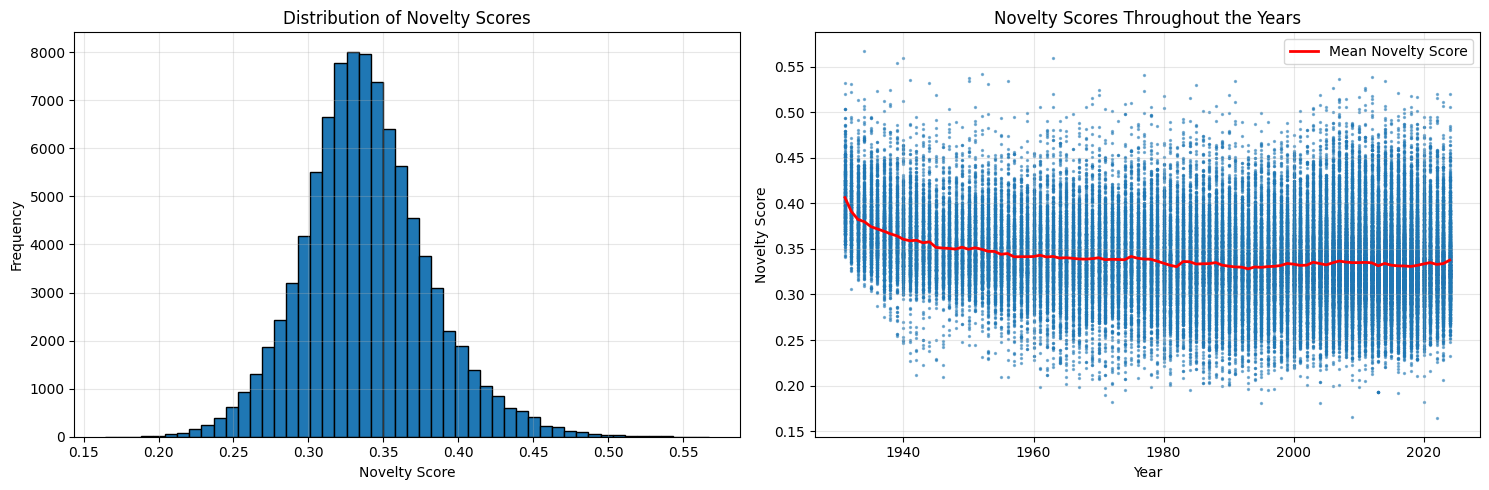

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Distribution of novelty scores
axes[0].hist(df_merged[df_merged['novelty_score'] > 0]['novelty_score'], bins=50, edgecolor='black')
axes[0].set_xlabel('Novelty Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Novelty Scores')
axes[0].grid(True, alpha=0.3)

# Plot 2: Novelty scores throughout the years
valid_data = df_merged[df_merged['novelty_score'] >= 0]
axes[1].scatter(valid_data['year'], valid_data['novelty_score'], alpha=0.5, s=2)
year_means = valid_data.groupby('year')['novelty_score'].mean()
axes[1].plot(year_means.index, year_means.values, color='red', linewidth=2, label='Mean Novelty Score')
axes[1].legend()
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Novelty Score')
axes[1].set_title('Novelty Scores Throughout the Years')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [55]:
top_20_novel_movies = df_merged[df_merged['year'] >= 2000].nlargest(20, 'novelty_score')[['movie_id', 'title', 'year', 'novelty_score']]
print(top_20_novel_movies)

         movie_id                                         title  year  \
69710    Q4895390                               Bert and Dickie  2012   
60038    Q7622483  Strawberry Shortcake: Berry Blossom Festival  2007   
73958   Q20756073                                     Democrats  2014   
58034    Q7622422                             Strawberry Fields  2006   
68075    Q5212960                  Dams: The Lethal Water Bombs  2011   
68024    Q3104320                                         Gerry  2011   
79104   Q24705117                       The Million Dollar Duck  2016   
89327  Q108612294                                      Petromax  2022   
91487  Q127709937                                   Diva Futura  2024   
54180   Q11663744                   In the Realms of the Unreal  2004   
83289   Q61085472                               Untamed Romania  2018   
69209    Q3521550                   The Lebanese Rocket Society  2012   
85142   Q64450077                           The Bla